<a href="https://colab.research.google.com/github/Zarak00/Data690_fall2022/blob/main/Projects%20/Colorectal_Histology_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run these codes if getting data from the drive
## Mounting Google Drive to Get data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip -q "/content/drive/MyDrive/JHU/bags_zarr.zip" -d "/content/unzipped_bags"

In [ ]:
# !ls unzipped_bags

bags_zarr


# Setup

In [ ]:
!pip install zarr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.9 MB/s eta 0:00:00


In [ ]:
import zarr
import os
import numpy as np
import imageio
from tqdm import tqdm
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
import tensorflow_datasets as tfds

## Load Dataset



In [ ]:
ds, info = tfds.load("colorectal_histology", as_supervised=True, with_info=True)
ds = ds["train"]  # The dataset provides a single "train" split

num_examples = info.splits["train"].num_examples
num_classes = info.features["label"].num_classes

print("Total samples:", num_examples)
print("Number of classes:", num_classes)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/incomplete.EYQYWY_2.0.0/colorectal_histology-train.tf…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
Total samples: 5000
Number of classes: 8


## Using datasets to make sets of tiles





In [ ]:
# placeholder for augmention function / method
def aug(x, y):
    return tf.image.random_flip_left_right(x), y

# label specific datasets as dictionary
ds_dict = dict(zip(info.features['label'].names, [
    ds.filter(lambda x, y: y == i).cache().shuffle(625, reshuffle_each_iteration=True).map(aug, tf.data.AUTOTUNE).repeat(tf.data.AUTOTUNE)
    for i in range(len(info.features['label'].names))]))

# keys of dict
ds_dict.keys()

dict_keys(['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty'])

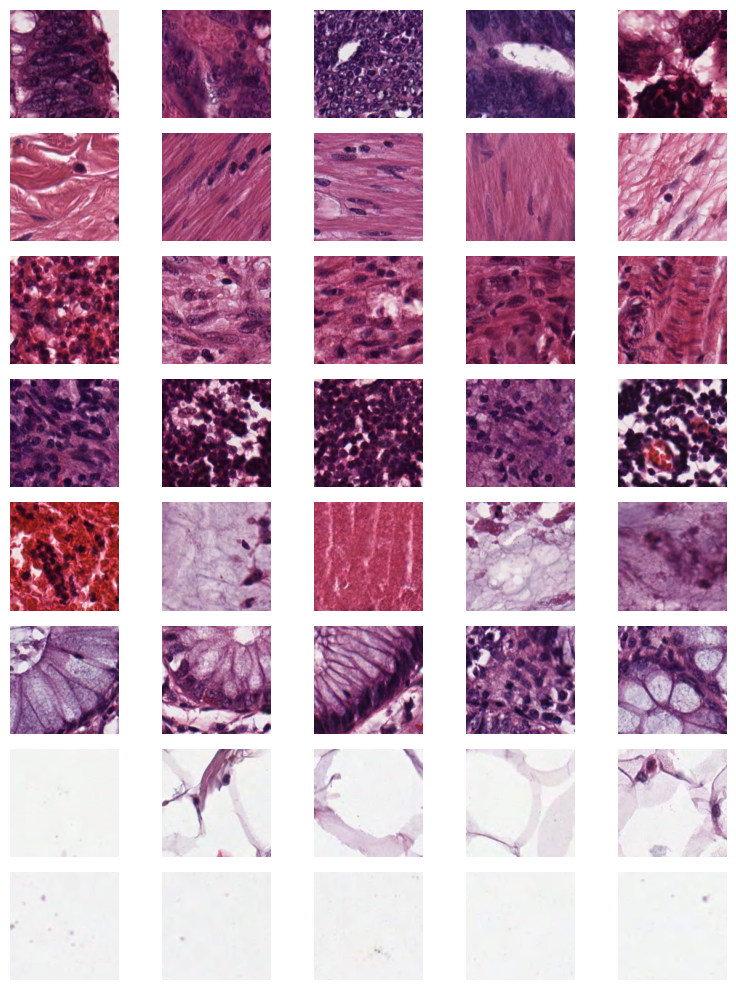

In [ ]:
# visualize and also enforcing the caching set above so that when we make datasets it is efficient
_, ax = plt.subplots(nrows=8, ncols=5, figsize=(8, 10))
for i, key in enumerate(ds_dict):
    img = next(iter(ds_dict[key].batch(5)))
    for j in range(5):
        ax[i, j].imshow(img[0][j])
        ax[i, j].axis('off')
plt.tight_layout()

In [ ]:
n = 200

# 0 is negative .1 to .4 is positive in the first column representing tumor tile
proportions = np.random.uniform(0.4, 0.8, 200)
proportions[np.random.choice(2, n)==0] = 0
proportions = np.concatenate([proportions[:, np.newaxis], np.exp(np.random.normal(0, 1, (n, 4)))], axis=1)
proportions /= proportions.sum(axis=1, keepdims=True)

In [ ]:
save_dir = "/content/unzipped_bags/bags_zarr"
os.makedirs(save_dir, exist_ok=True)

for i in range(n):
    # Generate synthetic bag
    X, y = next(iter(tf.data.Dataset.sample_from_datasets(
        [ds_dict['tumor'], ds_dict['mucosa'], ds_dict['stroma'], ds_dict['lympho'], ds_dict['adipose']],
        weights=proportions[i], stop_on_empty_dataset=False).batch(np.random.randint(100, 150))))

    y_counts = np.eye(8)[y].sum(axis=0)[[0, 5, 1, 3, 6]]

    X_np, y_np = X.numpy(), y.numpy()

    zarr_path = os.path.join(save_dir, f"bag_{i:04d}.zarr")
    z = zarr.open_group(zarr_path, mode='w')

    z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
    z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
    z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)

    print(f"[{i+1}/{n}] Saved: {zarr_path}")

<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[1/200] Saved: /content/unzipped_bags/bags_zarr/bag_0000.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[2/200] Saved: /content/unzipped_bags/bags_zarr/bag_0001.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[3/200] Saved: /content/unzipped_bags/bags_zarr/bag_0002.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[4/200] Saved: /content/unzipped_bags/bags_zarr/bag_0003.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[5/200] Saved: /content/unzipped_bags/bags_zarr/bag_0004.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[6/200] Saved: /content/unzipped_bags/bags_zarr/bag_0005.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[7/200] Saved: /content/unzipped_bags/bags_zarr/bag_0006.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[8/200] Saved: /content/unzipped_bags/bags_zarr/bag_0007.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[9/200] Saved: /content/unzipped_bags/bags_zarr/bag_0008.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[10/200] Saved: /content/unzipped_bags/bags_zarr/bag_0009.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[11/200] Saved: /content/unzipped_bags/bags_zarr/bag_0010.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[12/200] Saved: /content/unzipped_bags/bags_zarr/bag_0011.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[13/200] Saved: /content/unzipped_bags/bags_zarr/bag_0012.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[14/200] Saved: /content/unzipped_bags/bags_zarr/bag_0013.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[15/200] Saved: /content/unzipped_bags/bags_zarr/bag_0014.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[16/200] Saved: /content/unzipped_bags/bags_zarr/bag_0015.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[17/200] Saved: /content/unzipped_bags/bags_zarr/bag_0016.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[18/200] Saved: /content/unzipped_bags/bags_zarr/bag_0017.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[19/200] Saved: /content/unzipped_bags/bags_zarr/bag_0018.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[20/200] Saved: /content/unzipped_bags/bags_zarr/bag_0019.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[21/200] Saved: /content/unzipped_bags/bags_zarr/bag_0020.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[22/200] Saved: /content/unzipped_bags/bags_zarr/bag_0021.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[23/200] Saved: /content/unzipped_bags/bags_zarr/bag_0022.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[24/200] Saved: /content/unzipped_bags/bags_zarr/bag_0023.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[25/200] Saved: /content/unzipped_bags/bags_zarr/bag_0024.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[26/200] Saved: /content/unzipped_bags/bags_zarr/bag_0025.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[27/200] Saved: /content/unzipped_bags/bags_zarr/bag_0026.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[28/200] Saved: /content/unzipped_bags/bags_zarr/bag_0027.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[29/200] Saved: /content/unzipped_bags/bags_zarr/bag_0028.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[30/200] Saved: /content/unzipped_bags/bags_zarr/bag_0029.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[31/200] Saved: /content/unzipped_bags/bags_zarr/bag_0030.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[32/200] Saved: /content/unzipped_bags/bags_zarr/bag_0031.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[33/200] Saved: /content/unzipped_bags/bags_zarr/bag_0032.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[34/200] Saved: /content/unzipped_bags/bags_zarr/bag_0033.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[35/200] Saved: /content/unzipped_bags/bags_zarr/bag_0034.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[36/200] Saved: /content/unzipped_bags/bags_zarr/bag_0035.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[37/200] Saved: /content/unzipped_bags/bags_zarr/bag_0036.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[38/200] Saved: /content/unzipped_bags/bags_zarr/bag_0037.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[39/200] Saved: /content/unzipped_bags/bags_zarr/bag_0038.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[40/200] Saved: /content/unzipped_bags/bags_zarr/bag_0039.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[41/200] Saved: /content/unzipped_bags/bags_zarr/bag_0040.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[42/200] Saved: /content/unzipped_bags/bags_zarr/bag_0041.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[43/200] Saved: /content/unzipped_bags/bags_zarr/bag_0042.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[44/200] Saved: /content/unzipped_bags/bags_zarr/bag_0043.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[45/200] Saved: /content/unzipped_bags/bags_zarr/bag_0044.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[46/200] Saved: /content/unzipped_bags/bags_zarr/bag_0045.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[47/200] Saved: /content/unzipped_bags/bags_zarr/bag_0046.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[48/200] Saved: /content/unzipped_bags/bags_zarr/bag_0047.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[49/200] Saved: /content/unzipped_bags/bags_zarr/bag_0048.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[50/200] Saved: /content/unzipped_bags/bags_zarr/bag_0049.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[51/200] Saved: /content/unzipped_bags/bags_zarr/bag_0050.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[52/200] Saved: /content/unzipped_bags/bags_zarr/bag_0051.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[53/200] Saved: /content/unzipped_bags/bags_zarr/bag_0052.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[54/200] Saved: /content/unzipped_bags/bags_zarr/bag_0053.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[55/200] Saved: /content/unzipped_bags/bags_zarr/bag_0054.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[56/200] Saved: /content/unzipped_bags/bags_zarr/bag_0055.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[57/200] Saved: /content/unzipped_bags/bags_zarr/bag_0056.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[58/200] Saved: /content/unzipped_bags/bags_zarr/bag_0057.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[59/200] Saved: /content/unzipped_bags/bags_zarr/bag_0058.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[60/200] Saved: /content/unzipped_bags/bags_zarr/bag_0059.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[61/200] Saved: /content/unzipped_bags/bags_zarr/bag_0060.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[62/200] Saved: /content/unzipped_bags/bags_zarr/bag_0061.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[63/200] Saved: /content/unzipped_bags/bags_zarr/bag_0062.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[64/200] Saved: /content/unzipped_bags/bags_zarr/bag_0063.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[65/200] Saved: /content/unzipped_bags/bags_zarr/bag_0064.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[66/200] Saved: /content/unzipped_bags/bags_zarr/bag_0065.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[67/200] Saved: /content/unzipped_bags/bags_zarr/bag_0066.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[68/200] Saved: /content/unzipped_bags/bags_zarr/bag_0067.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[69/200] Saved: /content/unzipped_bags/bags_zarr/bag_0068.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[70/200] Saved: /content/unzipped_bags/bags_zarr/bag_0069.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[71/200] Saved: /content/unzipped_bags/bags_zarr/bag_0070.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[72/200] Saved: /content/unzipped_bags/bags_zarr/bag_0071.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[73/200] Saved: /content/unzipped_bags/bags_zarr/bag_0072.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[74/200] Saved: /content/unzipped_bags/bags_zarr/bag_0073.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[75/200] Saved: /content/unzipped_bags/bags_zarr/bag_0074.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[76/200] Saved: /content/unzipped_bags/bags_zarr/bag_0075.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[77/200] Saved: /content/unzipped_bags/bags_zarr/bag_0076.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[78/200] Saved: /content/unzipped_bags/bags_zarr/bag_0077.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[79/200] Saved: /content/unzipped_bags/bags_zarr/bag_0078.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[80/200] Saved: /content/unzipped_bags/bags_zarr/bag_0079.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[81/200] Saved: /content/unzipped_bags/bags_zarr/bag_0080.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[82/200] Saved: /content/unzipped_bags/bags_zarr/bag_0081.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[83/200] Saved: /content/unzipped_bags/bags_zarr/bag_0082.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[84/200] Saved: /content/unzipped_bags/bags_zarr/bag_0083.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[85/200] Saved: /content/unzipped_bags/bags_zarr/bag_0084.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[86/200] Saved: /content/unzipped_bags/bags_zarr/bag_0085.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[87/200] Saved: /content/unzipped_bags/bags_zarr/bag_0086.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[88/200] Saved: /content/unzipped_bags/bags_zarr/bag_0087.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[89/200] Saved: /content/unzipped_bags/bags_zarr/bag_0088.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[90/200] Saved: /content/unzipped_bags/bags_zarr/bag_0089.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[91/200] Saved: /content/unzipped_bags/bags_zarr/bag_0090.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[92/200] Saved: /content/unzipped_bags/bags_zarr/bag_0091.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[93/200] Saved: /content/unzipped_bags/bags_zarr/bag_0092.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[94/200] Saved: /content/unzipped_bags/bags_zarr/bag_0093.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[95/200] Saved: /content/unzipped_bags/bags_zarr/bag_0094.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[96/200] Saved: /content/unzipped_bags/bags_zarr/bag_0095.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[97/200] Saved: /content/unzipped_bags/bags_zarr/bag_0096.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[98/200] Saved: /content/unzipped_bags/bags_zarr/bag_0097.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[99/200] Saved: /content/unzipped_bags/bags_zarr/bag_0098.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[100/200] Saved: /content/unzipped_bags/bags_zarr/bag_0099.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[101/200] Saved: /content/unzipped_bags/bags_zarr/bag_0100.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[102/200] Saved: /content/unzipped_bags/bags_zarr/bag_0101.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[103/200] Saved: /content/unzipped_bags/bags_zarr/bag_0102.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[104/200] Saved: /content/unzipped_bags/bags_zarr/bag_0103.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[105/200] Saved: /content/unzipped_bags/bags_zarr/bag_0104.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[106/200] Saved: /content/unzipped_bags/bags_zarr/bag_0105.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[107/200] Saved: /content/unzipped_bags/bags_zarr/bag_0106.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[108/200] Saved: /content/unzipped_bags/bags_zarr/bag_0107.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[109/200] Saved: /content/unzipped_bags/bags_zarr/bag_0108.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[110/200] Saved: /content/unzipped_bags/bags_zarr/bag_0109.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[111/200] Saved: /content/unzipped_bags/bags_zarr/bag_0110.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[112/200] Saved: /content/unzipped_bags/bags_zarr/bag_0111.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[113/200] Saved: /content/unzipped_bags/bags_zarr/bag_0112.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[114/200] Saved: /content/unzipped_bags/bags_zarr/bag_0113.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[115/200] Saved: /content/unzipped_bags/bags_zarr/bag_0114.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[116/200] Saved: /content/unzipped_bags/bags_zarr/bag_0115.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[117/200] Saved: /content/unzipped_bags/bags_zarr/bag_0116.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[118/200] Saved: /content/unzipped_bags/bags_zarr/bag_0117.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[119/200] Saved: /content/unzipped_bags/bags_zarr/bag_0118.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[120/200] Saved: /content/unzipped_bags/bags_zarr/bag_0119.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[121/200] Saved: /content/unzipped_bags/bags_zarr/bag_0120.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[122/200] Saved: /content/unzipped_bags/bags_zarr/bag_0121.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[123/200] Saved: /content/unzipped_bags/bags_zarr/bag_0122.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[124/200] Saved: /content/unzipped_bags/bags_zarr/bag_0123.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[125/200] Saved: /content/unzipped_bags/bags_zarr/bag_0124.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[126/200] Saved: /content/unzipped_bags/bags_zarr/bag_0125.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[127/200] Saved: /content/unzipped_bags/bags_zarr/bag_0126.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[128/200] Saved: /content/unzipped_bags/bags_zarr/bag_0127.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[129/200] Saved: /content/unzipped_bags/bags_zarr/bag_0128.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[130/200] Saved: /content/unzipped_bags/bags_zarr/bag_0129.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[131/200] Saved: /content/unzipped_bags/bags_zarr/bag_0130.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[132/200] Saved: /content/unzipped_bags/bags_zarr/bag_0131.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[133/200] Saved: /content/unzipped_bags/bags_zarr/bag_0132.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[134/200] Saved: /content/unzipped_bags/bags_zarr/bag_0133.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[135/200] Saved: /content/unzipped_bags/bags_zarr/bag_0134.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[136/200] Saved: /content/unzipped_bags/bags_zarr/bag_0135.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[137/200] Saved: /content/unzipped_bags/bags_zarr/bag_0136.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[138/200] Saved: /content/unzipped_bags/bags_zarr/bag_0137.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[139/200] Saved: /content/unzipped_bags/bags_zarr/bag_0138.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[140/200] Saved: /content/unzipped_bags/bags_zarr/bag_0139.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[141/200] Saved: /content/unzipped_bags/bags_zarr/bag_0140.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[142/200] Saved: /content/unzipped_bags/bags_zarr/bag_0141.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[143/200] Saved: /content/unzipped_bags/bags_zarr/bag_0142.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[144/200] Saved: /content/unzipped_bags/bags_zarr/bag_0143.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[145/200] Saved: /content/unzipped_bags/bags_zarr/bag_0144.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


[146/200] Saved: /content/unzipped_bags/bags_zarr/bag_0145.zarr


<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])
<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[147/200] Saved: /content/unzipped_bags/bags_zarr/bag_0146.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[148/200] Saved: /content/unzipped_bags/bags_zarr/bag_0147.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[149/200] Saved: /content/unzipped_bags/bags_zarr/bag_0148.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[150/200] Saved: /content/unzipped_bags/bags_zarr/bag_0149.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[151/200] Saved: /content/unzipped_bags/bags_zarr/bag_0150.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[152/200] Saved: /content/unzipped_bags/bags_zarr/bag_0151.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[153/200] Saved: /content/unzipped_bags/bags_zarr/bag_0152.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[154/200] Saved: /content/unzipped_bags/bags_zarr/bag_0153.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[155/200] Saved: /content/unzipped_bags/bags_zarr/bag_0154.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[156/200] Saved: /content/unzipped_bags/bags_zarr/bag_0155.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[157/200] Saved: /content/unzipped_bags/bags_zarr/bag_0156.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[158/200] Saved: /content/unzipped_bags/bags_zarr/bag_0157.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[159/200] Saved: /content/unzipped_bags/bags_zarr/bag_0158.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[160/200] Saved: /content/unzipped_bags/bags_zarr/bag_0159.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[161/200] Saved: /content/unzipped_bags/bags_zarr/bag_0160.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[162/200] Saved: /content/unzipped_bags/bags_zarr/bag_0161.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[163/200] Saved: /content/unzipped_bags/bags_zarr/bag_0162.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[164/200] Saved: /content/unzipped_bags/bags_zarr/bag_0163.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[165/200] Saved: /content/unzipped_bags/bags_zarr/bag_0164.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[166/200] Saved: /content/unzipped_bags/bags_zarr/bag_0165.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[167/200] Saved: /content/unzipped_bags/bags_zarr/bag_0166.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[168/200] Saved: /content/unzipped_bags/bags_zarr/bag_0167.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[169/200] Saved: /content/unzipped_bags/bags_zarr/bag_0168.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[170/200] Saved: /content/unzipped_bags/bags_zarr/bag_0169.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[171/200] Saved: /content/unzipped_bags/bags_zarr/bag_0170.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[172/200] Saved: /content/unzipped_bags/bags_zarr/bag_0171.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[173/200] Saved: /content/unzipped_bags/bags_zarr/bag_0172.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[174/200] Saved: /content/unzipped_bags/bags_zarr/bag_0173.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[175/200] Saved: /content/unzipped_bags/bags_zarr/bag_0174.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[176/200] Saved: /content/unzipped_bags/bags_zarr/bag_0175.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[177/200] Saved: /content/unzipped_bags/bags_zarr/bag_0176.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[178/200] Saved: /content/unzipped_bags/bags_zarr/bag_0177.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[179/200] Saved: /content/unzipped_bags/bags_zarr/bag_0178.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[180/200] Saved: /content/unzipped_bags/bags_zarr/bag_0179.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[181/200] Saved: /content/unzipped_bags/bags_zarr/bag_0180.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[182/200] Saved: /content/unzipped_bags/bags_zarr/bag_0181.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[183/200] Saved: /content/unzipped_bags/bags_zarr/bag_0182.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[184/200] Saved: /content/unzipped_bags/bags_zarr/bag_0183.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[185/200] Saved: /content/unzipped_bags/bags_zarr/bag_0184.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[186/200] Saved: /content/unzipped_bags/bags_zarr/bag_0185.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[187/200] Saved: /content/unzipped_bags/bags_zarr/bag_0186.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[188/200] Saved: /content/unzipped_bags/bags_zarr/bag_0187.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[189/200] Saved: /content/unzipped_bags/bags_zarr/bag_0188.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[190/200] Saved: /content/unzipped_bags/bags_zarr/bag_0189.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[191/200] Saved: /content/unzipped_bags/bags_zarr/bag_0190.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[192/200] Saved: /content/unzipped_bags/bags_zarr/bag_0191.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[193/200] Saved: /content/unzipped_bags/bags_zarr/bag_0192.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[194/200] Saved: /content/unzipped_bags/bags_zarr/bag_0193.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[195/200] Saved: /content/unzipped_bags/bags_zarr/bag_0194.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[196/200] Saved: /content/unzipped_bags/bags_zarr/bag_0195.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[197/200] Saved: /content/unzipped_bags/bags_zarr/bag_0196.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[198/200] Saved: /content/unzipped_bags/bags_zarr/bag_0197.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)
<ipython-input-7-fe67abb45af3>:17: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("images", data=X_np, shape=X_np.shape, dtype=X_np.dtype, chunks=(1,) + X_np.shape[1:])


[199/200] Saved: /content/unzipped_bags/bags_zarr/bag_0198.zarr
[200/200] Saved: /content/unzipped_bags/bags_zarr/bag_0199.zarr


<ipython-input-7-fe67abb45af3>:18: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("labels", data=y_np, shape=y_np.shape, dtype=y_np.dtype, chunks=(100,))
<ipython-input-7-fe67abb45af3>:19: DeprecationWarning: Use Group.create_array instead.
  z.create_dataset("counts", data=y_counts, shape=y_counts.shape, dtype=y_counts.dtype)


## Convert Zarr Bags to Image Folders

- Loaded .zarr files that contain preprocessed image patches and numeric labels

- Read images and labels from each Zarr bag one at a time (to avoid memory issues)

- Saved each image as a .png file into folders grouped by label

- Created a clean folder structure for easy model training

- This step prepares the dataset for use with TensorFlow's image loading tools

In [ ]:
zarr_root = "/content/unzipped_bags/bags_zarr"
output_root = "/content/converted_data"
os.makedirs(output_root, exist_ok=True)

# Loop through each Zarr bag
for bag_name in tqdm(sorted(os.listdir(zarr_root))):
    if not bag_name.endswith(".zarr"):
        continue

    bag_path = os.path.join(zarr_root, bag_name)
    bag = zarr.open(bag_path, mode='r')

    images = bag["images"][:]
    labels = bag["labels"][:]

    for i, (img, label) in enumerate(zip(images, labels)):
        class_dir = os.path.join(output_root, f"class_{label}")
        os.makedirs(class_dir, exist_ok=True)

        img_path = os.path.join(class_dir, f"{bag_name}_{i}.png")
        imageio.imwrite(img_path, img)

100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


In [ ]:
!ls converted_data

!ls converted_data/class_0 | wc -l

class_0  class_1  class_3  class_5  class_6
1516


## Load Data in Tensor Flow dataset
- Loaded the converted image folders using image_dataset_from_directory()

- Split the data into 80% training and 20% validation using validation_split

- Resized all images to 224x224 to match the input size of pretrained models

- Applied batching to efficiently load data during training

- This step gives us a TensorFlow-compatible dataset (tf.data.Dataset)

In [ ]:
# Load data
data_dir = "converted_data"

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

Found 24701 files belonging to 5 classes.
Using 19761 files for training.
Found 24701 files belonging to 5 classes.
Using 4940 files for validation.


## Visuals

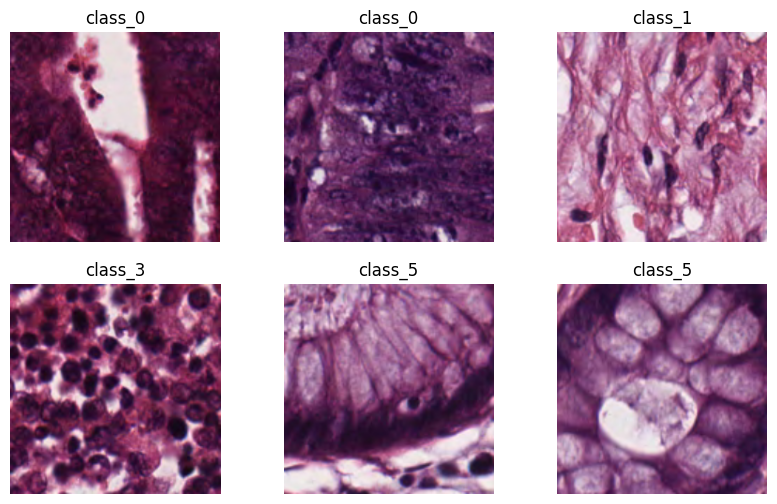

In [ ]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


## Preprocess the Dataset for EfficientNet
- preprocess_input() from EfficientNet, which normalizes pixel values to the expected format

- Used .map() to apply preprocessing to every image in both training and validation sets

- Enabled tf.data.AUTOTUNE to optimize performance during mapping

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocess(image, label):
    return preprocess_input(image), label

train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)


## Apply Data Augmentation
- Created a sequential augmentation pipeline with random horizontal flip, rotation, and zoom

- Applied these transformations only to the training dataset (not validation)

- Ensured augmentation is done on-the-fly during training — not saved to disk

- Used AUTOTUNE to optimize performance while mapping

In [ ]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

## Optimize Data Pipeline with Prefetching

- Used .prefetch(tf.data.AUTOTUNE) to overlap data preprocessing with model execution

- Improves performance by preparing the next batch while the model trains on the current one

- Applied to both training and validation datasets



In [ ]:
#3
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Loaded a pretrained EfficientNetB0 model (with ImageNet weights) as the base

- Set the base model as non-trainable to freeze feature extraction during initial training

- Added a classification head with:

- GlobalAveragePooling2D() to reduce features

- Dropout(0.3) for regularization

- Dense() layer with softmax activation for multi-class classification

- Used raw_ds.class_names to automatically detect number of output classes

In [ ]:
raw_ds = image_dataset_from_directory(
    "converted_data",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32
)

num_classes = len(raw_ds.class_names)


# Load EfficientNetB0 base
base_model = EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model for now

# Add classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

Found 24701 files belonging to 5 classes.
Using 19761 files for training.


## Compile the Model and Add Early Stopping
- Compiled the model using:

- Adam optimizer for efficient training

- SparseCategoricalCrossentropy for multi-class label integers

- Accuracy as the evaluation metric

- Added an EarlyStopping callback to:

- Monitor validation loss

Stop training if no improvement for 3 consecutive epochs

Restore the best model weights automatically

In [ ]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

## Training the model for 10 Epochs

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 247s 358ms/step - accuracy: 0.8828 - loss: 0.3816 - val_accuracy: 0.9733 - val_loss: 0.0961
Epoch 2/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 198s 319ms/step - accuracy: 0.9682 - loss: 0.1112 - val_accuracy: 0.9806 - val_loss: 0.0706
Epoch 3/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 202s 318ms/step - accuracy: 0.9730 - loss: 0.0845 - val_accuracy: 0.9844 - val_loss: 0.0586
Epoch 4/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 241s 389ms/step - accuracy: 0.9768 - loss: 0.0750 - val_accuracy: 0.9868 - val_loss: 0.0514
Epoch 5/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 197s 319ms/step - accuracy: 0.9778 - loss: 0.0717 - val_accuracy: 0.9883 - val_loss: 0.0459
Epoch 6/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 247s 399ms/step - accuracy: 0.9798 - loss: 0.0628 - val_accuracy: 0.9891 - val_loss: 0.0420
Epoch 7/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 214s 322ms/step - accuracy: 0.9809 - loss: 0.0622 - val_accuracy: 0.9891 - val_loss: 0.0402
Epoch 8/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 199s 322ms/step - accuracy: 0.9799 -

## Visualize Training and Validation Performance
- Plotted training and validation accuracy over epochs to track learning progress

- Plotted training and validation loss to monitor overfitting or underfitting

Helps understand whether the model is improving, plateauing, or overfitting

Used history.history object returned from model.fit()

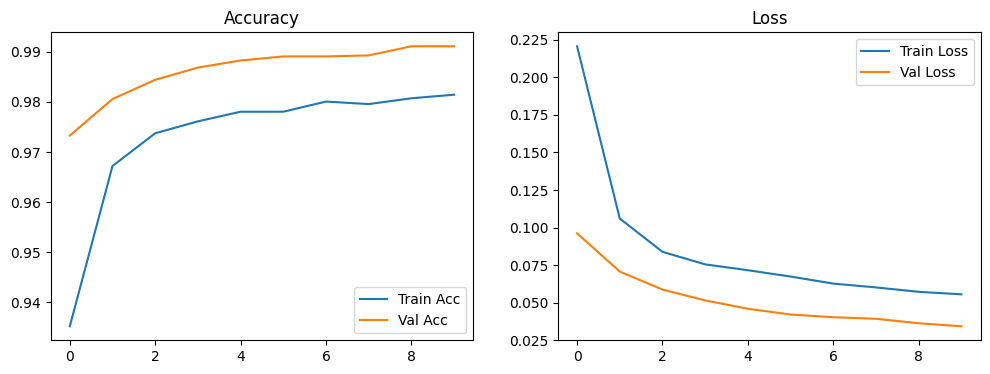

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"Final validation accuracy: {acc:.4f}")

155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.9915 - loss: 0.0355
Final validation accuracy: 0.9911


## Fine-tuning
- Unfreeze Base Model for Fine-Tuning

In [ ]:
base_model.trainable = True

## Recompile Model for Fine-Tuning
- Recompiled the model with a smaller learning rate (1e-5) to avoid destroying pretrained weights

- Continued using Adam optimizer and sparse categorical loss

- Keeps accuracy tracking during training

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # smaller LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Fine-Tune the Model
- Trained the model for additional epochs with base model unfrozen

- Used the same training and validation datasets

- Included EarlyStopping to stop if validation loss stops improving

- Collected new training history in fine_tune_history

In [ ]:
fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 336s 415ms/step - accuracy: 0.7565 - loss: 0.8032 - val_accuracy: 0.9630 - val_loss: 0.1165
Epoch 2/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 230s 331ms/step - accuracy: 0.9364 - loss: 0.1895 - val_accuracy: 0.9767 - val_loss: 0.0674
Epoch 3/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 210s 339ms/step - accuracy: 0.9589 - loss: 0.1240 - val_accuracy: 0.9844 - val_loss: 0.0478
Epoch 4/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 211s 341ms/step - accuracy: 0.9705 - loss: 0.0839 - val_accuracy: 0.9893 - val_loss: 0.0340
Epoch 5/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 211s 341ms/step - accuracy: 0.9779 - loss: 0.0643 - val_accuracy: 0.9909 - val_loss: 0.0259
Epoch 6/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 262s 341ms/step - accuracy: 0.9817 - loss: 0.0534 - val_accuracy: 0.9943 - val_loss: 0.0200
Epoch 7/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 209s 337ms/step - accuracy: 0.9839 - loss: 0.0445 - val_accuracy: 0.9943 - val_loss: 0.0157
Epoch 8/10
618/618 ━━━━━━━━━━━━━━━━━━━━ 318s 429ms/step - accuracy: 0.9871 -

In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"Final validation accuracy: {acc:.4f}")


155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9975 - loss: 0.0098
Final validation accuracy: 0.9972


## Visualize Fine-Tuning Performance
- Defined a reusable plot_history() function to display training progress

- Plotted accuracy and loss curves for both training and validation sets

- Used fine_tune_history to track performance during fine-tuning

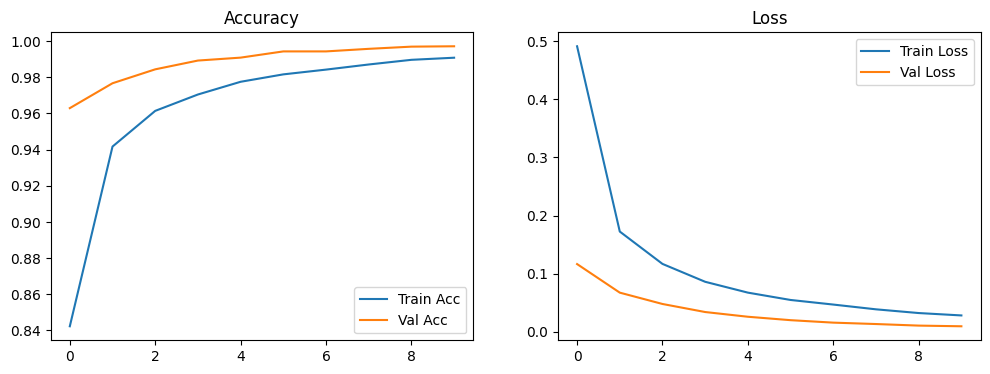

In [ ]:
import matplotlib.pyplot as plt

def plot_history(hist):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")
    plt.show()

plot_history(fine_tune_history)


In [ ]:
model.save("final_model.h5")  # or .keras